Importing a few things

In [1]:
# FUSEDWind imports
from fusedwind.plant_flow.vt import GenericWindFarmTurbineLayout, WTPC, WeibullWindRoseVT, GenericWindRoseVT


# Topfarm lib imports
from topfarm.aep import AEP
from topfarm.layout_distribution import spiral, DistributeSpiral, DistributeXY, DistributeFilledPolygon
from topfarm.plot import OffshorePlot, PrintOutputs, plot_wt_layout, plot_wind_rose
from topfarm.tlib import DistFromTurbines, PolyFill, document, DistFromBorders #,ConverHullArea
from topfarm.foundation import FoundationLength
from topfarm.elnet import ElNetLength, elnet
from topfarm.optimizers import *
from topfarm.topfarm import Topfarm

#GCL imports
from gclarsen.fusedwasp import PlantFromWWH, WTDescFromWTG
from gclarsen.fused import FGCLarsen

from numpy import *
import numpy as np

# For plotting
import pylab as plt

:0: FutureWarning: IPython widgets are experimental and may change in the future.


### Loading all the input data

In [2]:
datadir = './examples/notebook/'
dat = loadtxt(datadir+'WaterDepth1.dat')
X, Y = meshgrid(linspace(0., 1000., 50), linspace(0., 1000., 50))
depth = array(zip(X.flatten(), Y.flatten(), dat.flatten()))
borders = array([[200, 200], [150, 500], [200, 800], [600, 900], [700, 700], [900, 500], [800, 200], [500, 100], [200, 200]])
baseline = array([[587.5, 223.07692308], [525., 346.15384615], [837.5, 530.76923077], [525., 530.76923077], [525., 838.46153846], [837.5, 469.23076923]])

wt_desc = WTDescFromWTG(datadir+'V80-2MW-offshore.wtg').wt_desc
wt_layout = GenericWindFarmTurbineLayout([WTPC(wt_desc=wt_desc, position=pos) for pos in baseline])


# The wind rose
weibull_array = np.array([[  0.00000000e+00,   3.59673400e-02,  9.22422800e+00,   2.38867200e+00],
                         [  3.00000000e+01,   3.94977300e-02,   9.86435600e+00,   2.44726600e+00],
                         [  6.00000000e+01,   5.17838000e-02,   9.65220200e+00,   2.41992200e+00],
                         [  9.00000000e+01,   6.99794900e-02,   9.98217800e+00,   2.58789100e+00],
                         [  1.20000000e+02,   8.36383000e-02,   1.00946000e+01,   2.74804700e+00],
                         [  1.50000000e+02,   6.43412500e-02,   9.64369000e+00,   2.59179700e+00],
                         [  1.80000000e+02,   8.64220000e-02,   9.63377500e+00,   2.58007800e+00],
                         [  2.10000000e+02,   1.17690000e-01,   1.05678600e+01,   2.54492200e+00],
                         [  2.40000000e+02,   1.51555100e-01,   1.14525200e+01,   2.46679700e+00],
                         [  2.70000000e+02,   1.47361100e-01,   1.17423700e+01,   2.60351600e+00],
                         [  3.00000000e+02,   1.00109800e-01,   1.16923200e+01,   2.62304700e+00],
                         [  3.30000000e+02,   5.16542400e-02,   1.01385800e+01,   2.32226600e+00]])
wind_rose = WeibullWindRoseVT()
wind_rose.wind_directions = weibull_array[:,0]
wind_rose.frequency = weibull_array[:,1]
wind_rose.k = weibull_array[:,3]
wind_rose.A = weibull_array[:,2]

# Minimum distance between turbines
dist_WT_D = 3.0

# Plotting the inputs


Some matplotlib options

In [3]:
%matplotlib inline
import pylab as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
# To see all the options:
#plt.rcParams.keys()

#### Plotting the depth

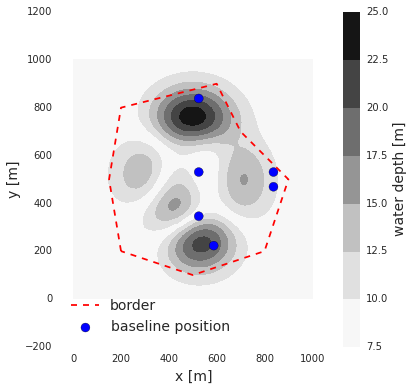

In [4]:
plot_wt_layout(wt_layout, borders, depth)

The red points indicate the position of the baseline turbines, the contour plot illustrate the water depth in meters and the red line illustrates the position of the borders limiting the domain of exploration of the optimization.

#### Plot the wind rose

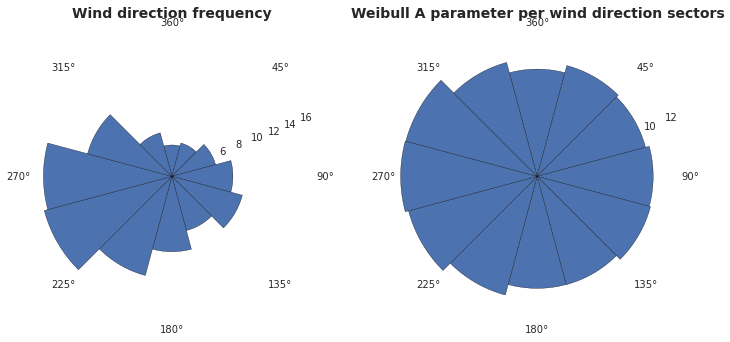

In [5]:
plot_wind_rose(wind_rose)

### Setting up TOPFARM

#### Calculating the wind farm AEP

In [6]:
ws = linspace(4, 25, 21)
wd = linspace(0, 360, 36)[:-1]

In [7]:
aep = AEP(wt_layout=wt_layout, 
          wind_rose=wind_rose, 
          wf=FGCLarsen(),
          wind_speeds=ws,
          wind_directions=wd,
          scaling=1.0,
          wt_positions=baseline)
aep.run()
print 'Net AEP=',aep.net_aep/1e6, 'MWh'

1.0
Net AEP= 50598.5402304 MWh


##### Exercise make a loop to plot the convergence of AEP vs the number of wind direction points

Sometimes it's practical to check what are the inputs / outputs of a component or driver

In [8]:
document(AEP)

**TODO**: fill in this doc


    
    Parameters
    ----------
    wind_speeds:    List, default=[], [m/s]
       The different wind speeds to run [nWS].
    
    scaling:    Float, default=1.0, [None]
       Scaling of the AEP.
    
    wind_directions:    List, default=[], [deg]
       The different wind directions to run [nWD].
    
    wt_positions:    Array, default=<undefined>, [None]
       None.
    
    
    Returns
    -------
    net_aep:    Float, [kW*h]
       Net Annual Energy Production after availability and loss impacts.
    
    array_aep:    Array, [kW*h]
       The energy production per sector [nWD, nWS].
    
    capacity_factor:    Float, [None]
       Capacity factor for wind plant.
    
    gross_aep:    Float, [kW*h]
       Gross Annual Energy Production before availability and loss impacts.
    
    


## Optimize only the foundation length

Here we don't consider the AEP for speeding things up.

KeyboardInterrupt: 

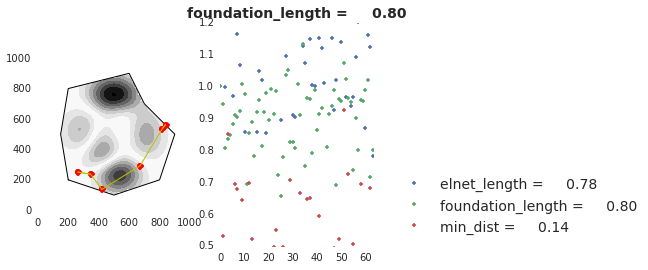

In [9]:
components = {
    'foundation': FoundationLength(borders=borders, scaling=0.0, depth=depth),
    'distribute': DistributeXY(wt_layout=wt_layout, borders=borders),
    'elnet': ElNetLength(scaling=0.0),
    'wt_dist': DistFromTurbines(scaling=wt_desc.rotor_diameter * dist_WT_D),
    'dist_from_borders': DistFromBorders(wt_layout=wt_layout, borders=borders, scaling=0.0),
    'plotting': OffshorePlot(baseline=baseline, borders=borders, depth=depth, distribution='xy', 
                             add_inputs=['elnet_length', 'foundation_length', 'min_dist' ],
                             title='foundation_length'),
## Using ALHSO from the pyOpt optimizer library
    'driver': PyoptOpt(method='ALHSO', # http://www.pyopt.org/reference/optimizers.alhso.html
        hms=10, #Memory Size [1,50]
        hmcr=0.8, #Probability rate of choosing from memory [0.7,0.99]
        par=0.65, #Pitch adjustment rate [0.1,0.99]
        dbw=2000, #Variable Bandwidth Quantization
        maxoutiter=2000, #Maximum Number of Outer Loop Iterations (Major Iterations)
        maxinniter=200, #Maximum Number of Inner Loop Iterations (Minor Iterations)
        stopcriteria=1, #Stopping Criteria Flag
        stopiters=10, #Consecutively Number of Outer Iterations for convergence
        etol=1e-6, #Absolute Tolerance for Equality constraints
        itol=1e-6, #Absolute Tolerance for Inequality constraints
        atol=1e-6, #Absolute Tolerance for Objective Function
        rtol=1e-6, #Relative Tolerance for Objective Function
        prtoutiter=0, #Number of Iterations Before Print Outer Loop Information
        prtinniter=0, #Number of Iterations Before Print Inner Loop Information
        xinit=0, #Initial Position Flag (0 - no position, 1 - position given)
        rinit=1.0, #Initial Penalty Factor
        fileout=1, #Flag to Turn On Output to filename
        filename='ALHSO.out', #Output File Name
        seed=0.,#Random Number Seed (0 - Auto-Seed based on time clock)
        scaling=1, #Design Variables Scaling (0- no scaling, 1- scaling [-1,1])                       
           

## Using the basic openmdao optimizers
#   'driver': COBYLAOpt(rhobeg=1)}

## Using IpOpt
#    'driver': IpOpt(output_file='ipopt.out',
#                    derivative_test='first-order',
#                    point_perturbation_radius=1.,
#                    derivative_test_print_all='yes',
#                    findiff_perturbation=1.e-6)}

)}



workflows =   {'driver': ['distribute', 'foundation','wt_dist', 'elnet', 'dist_from_borders', 'plotting']}

#objectives =  {'driver': 'foundation.foundation_length'}
objectives =  {'driver': '0.5 * foundation.foundation_length + 0.5*elnet.elnet_length'}

constraints = {'driver': ['wt_dist.min_dist>0.8', 
                          'elnet.elnet_length<1.1', 
                          'dist_from_borders'
                          ]}

design_variables = {'driver': 'distribute'}

connections = {'distribute.wt_positions': ['foundation.wt_positions',
                                            'wt_dist.wt_positions',
                                            'plotting.wt_positions',
                                           'elnet.wt_positions',
                                          'dist_from_borders.wt_positions'],
               'foundation.foundation_length': 'plotting.foundation_length',
               'foundation.foundations': 'plotting.foundations',
               'elnet.elnet_layout': 'plotting.elnet_layout',
               'elnet.elnet_length': 'plotting.elnet_length',               
               'wt_dist.min_dist': 'plotting.min_dist'}

input_parameters = {}

top = Topfarm(components, workflows, objectives, constraints, design_variables, connections, input_parameters)
top.run()

# Saving the new position as baseline for the next optimization
baseline = top.distribute.wt_positions


The `components` dictionary contains the different models inside the workflow. The `components['driver']` is the optimizer. You can select other ones from this list of basic optimizers: 

* CONMINOpt
* NEWSUMTOpt
* COBYLAOpt
* SLSQPOpt
* GeneticOpt


There are also optimizers available through the pyOpt library:
http://www.pyopt.org


In [ ]:
pyopt_methods = ['ALHSO', 'ALPSO', 'COBYLA', 'CONMIN', 'KSOPT', 'MIDACO', 'NSGA2', 'PSQP', 'SLSQP', 'SOLVOPT']

## Optimization using the AEP

In [ ]:
components = {
    'elnet': ElNetLength(scaling=0.0),
    'foundation': FoundationLength(borders=borders, scaling=0.0, depth=depth),
    'aep': AEP(wt_layout=wt_layout, 
               wind_rose=wind_rose, 
               wf=FGCLarsen(),
               wind_speeds=[4, 8, 12],
               wind_directions=linspace(0, 360, 12)[:-1],
               scaling=0.0),
    #'area': ConverHullArea(wt_layout=wt_layout, scaling=0.0),
    'dist_from_borders': DistFromBorders(wt_layout=wt_layout, borders=borders, scaling=0.0),    
    'wt_dist': DistFromTurbines(scaling=wt_desc.rotor_diameter * dist_WT_D),
    'distribute': DistributeXY(wt_layout=wt_layout, borders=borders),
    'plotting': OffshorePlot(baseline=baseline, borders=borders, depth=depth, distribution='xy',
                             add_inputs=['area', 'capacity_factor', 'elnet_length', 'net_aep', 'foundation_length', 'min_dist' ],
                             title='capacity_factor'),
    'driver': COBYLAOpt(rhobeg=1)}
workflows =   {'driver': ['distribute', 'foundation', 'elnet', 'aep', 'dist_from_borders', 'wt_dist', 'plotting']}

objectives =  {'driver': '-aep.net_aep'}
# objectives =  {'driver': '-aep.net_aep + 0.4*elnet.elnet_length'}
#objectives =  {'driver': '-aep.capacity_factor/area.area'}

constraints = {'driver': ['wt_dist.min_dist>0.8',
                          'foundation.foundation_length<1.02',
                         'dist_from_borders'
                         #'foundation.foundation_length<1.02',
                         #'elnet.elnet_length<1.02',
                          ]}

design_variables = {'driver': 'distribute'}

connections = {'distribute.wt_positions': ['foundation.wt_positions',
                                            'elnet.wt_positions',
                                            'wt_dist.wt_positions',
                                            'aep.wt_positions',
                                            'plotting.wt_positions',
                                           'dist_from_borders.wt_positions',
                                           #'area.wt_positions'
                                          ],
               'foundation.foundation_length': 'plotting.foundation_length',
               'foundation.foundations': 'plotting.foundations',
               'elnet.elnet_layout': 'plotting.elnet_layout',
               'elnet.elnet_length': 'plotting.elnet_length',
               'wt_dist.min_dist': 'plotting.min_dist',
               'aep.capacity_factor': 'plotting.capacity_factor',
               'aep.net_aep': 'plotting.net_aep',
               #'area.area': 'plotting.area'
              }

input_parameters = {}
top2 = Topfarm(components, workflows, objectives, constraints, design_variables, connections, input_parameters)
top2.run()

Copying the new positions of the turbines

In [ ]:
baseline = top2.distribute.wt_positions

Plotting the new positions

In [ ]:
plot_wt_layout(wt_layout, borders, depth)

Calculating the new AEP with a higher wind rose accuracy

In [ ]:
ws = linspace(4, 25, 21)
wd = linspace(0, 360, 181)[:-1]
aep = AEP(wt_layout=wt_layout, 
          wind_rose=wind_rose, 
          wf=FGCLarsen(),
          wind_speeds=ws,
          wind_directions=wd,
          scaling=1.0,
          wt_positions=baseline)
aep.run()
print 'Net AEP=',aep.net_aep/1e6, 'MWh'